In [1]:
import math
import pickle
import numpy as np
import pandas as pd
import argparse
import torch
from torch import nn
import torch.nn.functional as F
from train_functions import *
from feature_functions import load_pickle, dump_pickle

from torch.autograd import Variable
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import warnings
import random



parser = argparse.ArgumentParser(description='Inputs: --train_path: train data path; --test_path: test data path;\
                        --lr: learning rate;--batch: batch size; --lr_decay:multiplicative factor of learning rate decay. Default: 0.5;\
                        --decay_interval: period of learning rate decay; --num_epoch: the number of epochs;\
                        --param_dict_pkl: the path to parameters; --shuffle_T: shuffle temperature feature if True. Default=False')
    
parser.add_argument('--train_path', default='../data/')
parser.add_argument('--test_path', default='../data/')
parser.add_argument('--lr', default = 0.001, type=float )
parser.add_argument('--batch', default = 8 , type=int )
parser.add_argument('--lr_decay', default = 0.5, type=float )
parser.add_argument('--decay_interval', default = 10, type=int )
parser.add_argument('--num_epoch', default = 1, type=int )
parser.add_argument('--seed', default = 42, type=int )
parser.add_argument('--param_dict_pkl', default = '../data/hyparams/param_2.pkl')
parser.add_argument('--shuffle_T', default = 'False', choices=['False','True'], type = str )
# args = parser.parse_args()
args, unknown = parser.parse_known_args()


train_path, test_path, lr, batch_size, lr_decay, decay_interval, param_dict_pkl = \
        str(args.train_path), str(args.test_path), float(args.lr), int(args.batch), \
        float(args.lr_decay), int(args.decay_interval) , str( args.param_dict_pkl )

print('Loading train data from %s .' % train_path)
if not ( os.path.isdir(train_path) ):
    raise SystemExit('Directory %s does not exist!' % train_path )
    
print('Loading test data from %s .' % test_path)
if not ( os.path.isdir(test_path) ):
    raise SystemExit('Directory %s does not exist!' % test_path )
    
print('Loading parameters from %s .' % param_dict_pkl)
if not ( os.path.exists(param_dict_pkl) ):
    raise SystemExit('File %s does not exist!' % param_dict_pkl )
    
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.manual_seed_all(args.seed)

print(args)

param_dict = load_pickle(param_dict_pkl)
comp_dim, prot_dim, gat_dim, num_head, dropout, alpha, window, layer_cnn, latent_dim, layer_out = \
        param_dict['comp_dim'], param_dict['prot_dim'],param_dict['gat_dim'],param_dict['num_head'],\
        param_dict['dropout'], param_dict['alpha'], param_dict['window'], param_dict['layer_cnn'], \
        param_dict['latent_dim'], param_dict['layer_out']

print(param_dict)
warnings.filterwarnings("ignore", message="Setting attributes on ParameterList is not supported.")

/opt/anaconda3/envs/Uni_test/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading train data from ../data/ .
Loading test data from ../data/ .
Loading parameters from ../data/hyparams/param_2.pkl .
Namespace(batch=8, decay_interval=10, lr=0.001, lr_decay=0.5, num_epoch=1, param_dict_pkl='../data/hyparams/param_2.pkl', seed=42, shuffle_T='False', test_path='../data/', train_path='../data/')
{'comp_dim': 80, 'prot_dim': 80, 'gat_dim': 50, 'num_head': 3, 'dropout': 0.1, 'alpha': 0.1, 'window': 5, 'layer_cnn': 4, 'latent_dim': 40, 'layer_out': 4}


In [2]:
atom_dict = load_pickle(  '../data/dict/fingerprint_dict.pkl' )
word_dict = load_pickle(   '../data/dict/word_dict.pkl' )

datapack = load_data(train_path, True, 'train')
test_data = load_data(test_path, True, 'test')

train_data, dev_data = split_data( datapack, 0.1 )

num_epochs = int( args.num_epoch )#fixed value


In [3]:
class GATLayer(nn.Module):

    def __init__(self, in_features, out_features, dropout=0.5, alpha=0.2, concat=True):
        super(GATLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.empty(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.empty(size=(2 * out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

    def forward(self, h, adj):
        Wh = torch.matmul(h, self.W)
        a_input = self._prepare_attentional_mechanism_input(Wh)
        e = F.leaky_relu(torch.matmul(a_input, self.a).squeeze(3), self.alpha)

        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=2)
        # attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.bmm(attention, Wh)

        return F.elu(h_prime) if self.concat else h_prime

    def _prepare_attentional_mechanism_input(self, Wh):
        b = Wh.size()[0]
        N = Wh.size()[1]

        Wh_repeated_in_chunks = Wh.repeat_interleave(N, dim=1)
        Wh_repeated_alternating = Wh.repeat_interleave(N, dim=0).view(b, N*N, self.out_features)
        all_combinations_matrix = torch.cat([Wh_repeated_in_chunks, Wh_repeated_alternating], dim=2)

        return all_combinations_matrix.view(b, N, N, 2 * self.out_features)


class KcatModel(nn.Module):
    def __init__(self, n_atom, n_amino, comp_dim, prot_dim, gat_dim, num_head, dropout, alpha, window, layer_cnn, latent_dim, layer_out ):
        super(KcatModel, self).__init__()
        '''
        n_atom here stands for number of atom_features
        '''


        self.embedding_layer_atom = nn.Embedding(n_atom+1, comp_dim)
        self.embedding_layer_amino = nn.Embedding(n_amino+1, prot_dim)

        self.dropout = dropout
        self.alpha = alpha
        self.layer_cnn = layer_cnn
        self.latent_dim = latent_dim
        self.layer_out = layer_out

        self.gat_layers = [GATLayer(comp_dim, gat_dim, dropout=dropout, alpha=alpha, concat=True)
                           for _ in range(num_head)]
        for i, layer in enumerate(self.gat_layers):
            self.add_module('gat_layer_{}'.format(i), layer)
        self.gat_out = GATLayer(gat_dim * num_head, comp_dim, dropout=dropout, alpha=alpha, concat=False)
        self.W_comp = nn.Linear(comp_dim, latent_dim)

        self.conv_layers = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2*window+1,
                                                    stride=1, padding=window) for _ in range(layer_cnn)])
        self.W_prot = nn.Linear(prot_dim, latent_dim)

        self.fp0 = nn.Parameter(torch.empty(size=(1024, latent_dim)))
        nn.init.xavier_uniform_(self.fp0, gain=1.414)
        self.fp1 = nn.Parameter(torch.empty(size=(latent_dim, latent_dim)))
        nn.init.xavier_uniform_(self.fp1, gain=1.414)

        self.bidat_num = 4

        self.U = nn.ParameterList([nn.Parameter(torch.empty(size=(latent_dim, latent_dim))) for _ in range(self.bidat_num)])
        for i in range(self.bidat_num):
            nn.init.xavier_uniform_(self.U[i], gain=1.414)

        self.transform_c2p = nn.ModuleList([nn.Linear(latent_dim, latent_dim) for _ in range(self.bidat_num)])
        self.transform_p2c = nn.ModuleList([nn.Linear(latent_dim, latent_dim) for _ in range(self.bidat_num)])

        self.bihidden_c = nn.ModuleList([nn.Linear(latent_dim, latent_dim) for _ in range(self.bidat_num)])
        self.bihidden_p = nn.ModuleList([nn.Linear(latent_dim, latent_dim) for _ in range(self.bidat_num)])
        self.biatt_c = nn.ModuleList([nn.Linear(latent_dim * 2, 1) for _ in range(self.bidat_num)])
        self.biatt_p = nn.ModuleList([nn.Linear(latent_dim * 2, 1) for _ in range(self.bidat_num)])

        self.comb_c = nn.Linear(latent_dim * self.bidat_num, latent_dim)
        self.comb_p = nn.Linear(latent_dim * self.bidat_num, latent_dim)
   
        self.W_out = nn.ModuleList([nn.Linear(latent_dim * 3 + 2, latent_dim * 3 + 2)
                                    for _ in range(self.layer_out)])
    
        self.output = nn.Linear(latent_dim * 3 + 2, 1)


    def comp_gat(self, atoms, adj):
        atoms_vector = self.embedding_layer_atom(atoms)
        atoms_multi_head = torch.cat([gat(atoms_vector, adj) for gat in self.gat_layers], dim=2)
        atoms_vector = F.elu(self.gat_out(atoms_multi_head, adj))
        atoms_vector = F.leaky_relu(self.W_comp(atoms_vector), self.alpha)
        return atoms_vector #(B,L, 40)

    def prot_cnn(self, amino ):
        amino_vector = self.embedding_layer_amino(amino)
        amino_vector = torch.unsqueeze(amino_vector, 1)
        for i in range(self.layer_cnn):
            amino_vector = F.leaky_relu(self.conv_layers[i](amino_vector), self.alpha)
        amino_vector = torch.squeeze(amino_vector, 1)
        amino_vector = F.leaky_relu(self.W_prot(amino_vector), self.alpha)
        return amino_vector

    def mask_softmax(self, a, mask, dim=-1):
        a_max = torch.max(a, dim, keepdim=True)[0]
        a_exp = torch.exp(a - a_max)
        a_exp = a_exp * mask
        a_softmax = a_exp / (torch.sum(a_exp, dim, keepdim=True) + 1e-6)
        return a_softmax

    def bidirectional_attention_prediction(self,atoms_vector, atoms_mask, fps, amino_vector, amino_mask, inv_Temp, Temp):
        b = atoms_vector.shape[0]
        for i in range(self.bidat_num):
            A = torch.tanh(torch.matmul(torch.matmul(atoms_vector, self.U[i]), amino_vector.transpose(1, 2)))
            A = A * torch.matmul(atoms_mask.view(b, -1, 1), amino_mask.view(b, 1, -1))

            atoms_trans = torch.matmul(A, torch.tanh(self.transform_p2c[i](amino_vector)))
            amino_trans = torch.matmul(A.transpose(1, 2), torch.tanh(self.transform_c2p[i](atoms_vector)))

            atoms_tmp = torch.cat([torch.tanh(self.bihidden_c[i](atoms_vector)), atoms_trans], dim=2)
            amino_tmp = torch.cat([torch.tanh(self.bihidden_p[i](amino_vector)), amino_trans], dim=2)

            atoms_att = self.mask_softmax(self.biatt_c[i](atoms_tmp).view(b, -1), atoms_mask.view(b, -1))
            amino_att = self.mask_softmax(self.biatt_p[i](amino_tmp).view(b, -1), amino_mask.view(b, -1))

            cf = torch.sum(atoms_vector * atoms_att.view(b, -1, 1), dim=1)
            pf = torch.sum(amino_vector * amino_att.view(b, -1, 1), dim=1)

            if i == 0:
                cat_cf = cf
                cat_pf = pf
            else:
                cat_cf = torch.cat([cat_cf.view(b, -1), cf.view(b, -1)], dim=1)
                cat_pf = torch.cat([cat_pf.view(b, -1), pf.view(b, -1)], dim=1)

        inverse_Temp = inv_Temp.view(inv_Temp.shape[0],-1)
        Temperature = Temp.view(Temp.shape[0],-1)

        # plan_1: get means
        # cf = self.comb_c(cat_cf).view(b, -1)
        # cf = torch.mean(cf, dim=1, keepdim=True)
        # pf = self.comb_p(cat_pf)
        # pf = torch.mean(pf, dim=1, keepdim=True)
        # fps = fps.view(b, -1)
        # fps = torch.mean(fps, dim=1, keepdim=True)
        
        # plan_2: only replace the last output MLP
        # cf_final = torch.cat([self.comb_c(cat_cf).view(b, -1), fps.view(b, -1)], dim=1)#length = 2*d
        # pf_final = self.comb_p(cat_pf)#length = d
        # cat_vector = torch.cat((cf_final, pf_final, inverse_Temp, Temperature), dim=1)#length=3*d+2
        # return cat_vector
        # for j in range(self.layer_out):
        #     cat_vector = F.leaky_relu(self.W_out[j](cat_vector), self.alpha ) 
        # return self.output(cat_vector)

        #plan_3: different MLPs for different tensors
        cf = self.comb_c(cat_cf).view(b, -1)
        fps = fps.view(b, -1)
        pf = self.comb_p(cat_pf)

        return cf, fps, pf, inverse_Temp, Temperature

    def forward(self, atoms, atoms_mask, adjacency, amino, amino_mask, fps, inv_Temp, Temp ):
        atoms_vector = self.comp_gat(atoms, adjacency)
        amino_vector = self.prot_cnn( amino )


        super_feature = F.leaky_relu(torch.matmul(fps, self.fp0), 0.1)
        super_feature = F.leaky_relu(torch.matmul(super_feature, self.fp1), 0.1)

        prediction = self.bidirectional_attention_prediction( atoms_vector, atoms_mask, super_feature,\
                                                             amino_vector, amino_mask, inv_Temp, Temp )
        
        
        return prediction
    
class New_MLP(nn.Module):
    def __init__(self, n_atom, n_amino, comp_dim, prot_dim, gat_dim, num_head, dropout, alpha, window, layer_cnn, latent_dim, layer_out ):
        super(New_MLP, self).__init__()
        self.alpha = alpha
        self.W_final_1 = nn.ModuleList([nn.Linear(latent_dim, latent_dim) for _ in range(3)])
        self.W_final_2 = nn.ModuleList([nn.Linear(latent_dim, 1) for _ in range(3)])
        self.W_final_3 = nn.Linear(5, 1)

    def forward(self, cf, fps, pf, inverse_Temp, Temperature):
        #plan_3: same MLPs for different tensors
        cf_final = F.leaky_relu(self.W_final_2[0](F.leaky_relu(self.W_final_1[0](cf), self.alpha)), self.alpha)
        fps_final = F.leaky_relu(self.W_final_2[1](F.leaky_relu(self.W_final_1[1](fps), self.alpha)), self.alpha)
        pf_final = F.leaky_relu(self.W_final_2[2](F.leaky_relu(self.W_final_1[2](pf), self.alpha)), self.alpha)   
        cat_vector = torch.cat((cf_final, fps_final, pf_final, inverse_Temp, Temperature), dim=1)
        return self.W_final_3(cat_vector), cat_vector


class New_MLP_Independent(nn.Module):
    def __init__(self, n_atom, n_amino, comp_dim, prot_dim, gat_dim, num_head, dropout, alpha, window, layer_cnn, latent_dim, layer_out ):
        super(New_MLP_Independent, self).__init__()
        self.alpha = alpha
        self.W_final_1 = nn.ModuleList([nn.Linear(latent_dim*3, latent_dim*3) for _ in range(3)])
        self.W_final_2 = nn.Linear(latent_dim*3, 3)
        self.W_final_3 = nn.Linear(5, 1)

    def forward(self, cf, fps, pf, inverse_Temp, Temperature):
        #plan_3: different MLPs for different tensors
        cat_vector = torch.cat((cf, fps, pf), dim=1)
        for j in range(3):
            cat_vector = F.leaky_relu(self.W_final_1[j](cat_vector), self.alpha ) 
        
        cat_vector = F.leaky_relu(self.W_final_2(cat_vector), self.alpha ) 
        cat_vector = torch.cat((cat_vector, inverse_Temp, Temperature), dim=1)
        return self.W_final_3(cat_vector), cat_vector

def test(model, model_mlp, data_test, batch_size, device):
    model.eval()
    predictions = []
    labels = []
    for i in range(math.ceil(len(data_test[0]) / batch_size)):
        batch_data = [data_test[di][i * batch_size: (i + 1) * batch_size] for di in range(len(data_test))]
        atoms_pad, atoms_mask, adjacencies_pad, batch_fps, amino_pad,\
                    amino_mask, inv_Temp, Temp, label = DLTKcat_batch2tensor(batch_data, True, device)
        
        with torch.no_grad():
            cf, fps, pf, inverse_Temp, Temperature = model( atoms_pad, atoms_mask, adjacencies_pad, amino_pad, amino_mask, batch_fps, inv_Temp, Temp )
            pred, _ = model_mlp(cf, fps, pf, inverse_Temp, Temperature)
            
        predictions += pred.cpu().detach().numpy().reshape(-1).tolist()
        labels += label.cpu().numpy().reshape(-1).tolist()
        
    predictions = np.array(predictions)
    labels = np.array(labels)
    rmse, r2 = scores(labels, predictions)
    
    return rmse, r2
    

In [4]:

def train_eval(model, model_mlp, data_train, data_test, data_dev, device, lr, batch_size, lr_decay, decay_interval, num_epochs ):
    criterion = F.mse_loss
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0, amsgrad=True)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size= decay_interval, gamma=lr_decay)
    idx = np.arange(len(data_train[0]))
    
    min_size = 4   #4
    if batch_size > min_size:
        div_min = int(batch_size / min_size)
    else:
        div_min = 1
        
    rmse_train_scores, r2_train_scores, rmse_test_scores, r2_test_scores, rmse_dev_scores, r2_dev_scores = [],[],[],[],[],[]
    for epoch in range(num_epochs):
             
        np.random.shuffle(idx)
        model.train()
        predictions = []
        labels = []
        for i in range(math.ceil( len(data_train[0]) / min_size )):
            batch_data = [data_train[di][idx[ i* min_size: (i + 1) * min_size]] \
                          for di in range(len(data_train))]
            atoms_pad, atoms_mask, adjacencies_pad, batch_fps, amino_pad,\
                            amino_mask, inv_Temp, Temp, label = DLTKcat_batch2tensor(batch_data, True, device)
            
            cf, fps, pf, inverse_Temp, Temperature = model( atoms_pad, atoms_mask, adjacencies_pad, amino_pad, amino_mask, batch_fps, inv_Temp, Temp )
            pred, _ = model_mlp(cf, fps, pf, inverse_Temp, Temperature)
            loss = criterion(pred.float(), label.float())
            predictions += pred.cpu().detach().numpy().reshape(-1).tolist()
            labels += label.cpu().numpy().reshape(-1).tolist()
            loss.backward()
            if i % div_min == 0 and i != 0:    
                optimizer.step()
                optimizer.zero_grad()

        
        predictions = np.array(predictions)
        labels = np.array(labels)
        rmse_train, r2_train = scores( labels, predictions )
        rmse_dev, r2_dev = test( model, model_mlp, data_dev, batch_size, device ) #dev dataset
        rmse_test, r2_test = test(model, model_mlp, data_test, batch_size, device) # test dataset
        
        if rmse_test < 0.91:
            print('Best model found at epoch=' + str(epoch) + '!')
            best_model_pth = '../data/my_performance/model_latentdim=' + str(model.latent_dim) + '_outlayer=' + str(model.layer_out)
            best_model_pth = best_model_pth + '_rmsetest='+str( round(rmse_test,4) )+'_rmsedev='+str( round(rmse_dev,4) ) +'.pth'
            torch.save( model.state_dict(), best_model_pth)


        rmse_train_scores.append( rmse_train )
        r2_train_scores.append( r2_train )
        rmse_dev_scores.append( rmse_dev )
        r2_dev_scores.append( r2_dev )
        rmse_test_scores.append( rmse_test )
        r2_test_scores.append( r2_test )

        
        print('epoch: '+str(epoch)+'/'+ str(num_epochs) +';  rmse test: ' + str(rmse_test) + '; r2 test: ' + str(r2_test) )
        

        scheduler.step()
        
    return rmse_train_scores, r2_train_scores, rmse_test_scores, r2_test_scores, rmse_dev_scores, r2_dev_scores 

In [ ]:
model = KcatModel( len(atom_dict), len(word_dict), comp_dim, prot_dim, gat_dim, num_head, \
                          dropout, alpha, window, layer_cnn, latent_dim, layer_out )
model.to(device)
# model.load_state_dict(torch.load('../data/performances/model_latentdim=40_outlayer=4_rmsetest=0.8854_rmsedev=0.908.pth', map_location=device))

model_mlp = New_MLP_Independent( len(atom_dict), len(word_dict), comp_dim, prot_dim, gat_dim, num_head, \
                          dropout, alpha, window, layer_cnn, latent_dim, layer_out )
model_mlp.to(device)
rmse_train_scores, r2_train_scores, rmse_test_scores, r2_test_scores ,rmse_dev_scores, r2_dev_scores = \
        train_eval(model, model_mlp , train_data, test_data, dev_data, device, lr, batch_size, lr_decay,\
                   decay_interval, num_epochs=1)

In [5]:
# torch.save(model.state_dict(), '../data/my_performance/DLTKcat_finetune.pth')
# torch.save(model_mlp.state_dict(), '../data/my_performance/mlp.pth')

model = KcatModel( len(atom_dict), len(word_dict), comp_dim, prot_dim, gat_dim, num_head, \
                          dropout, alpha, window, layer_cnn, latent_dim, layer_out )
model.to(device)
model.load_state_dict(torch.load('../data/my_performance/DLTKcat_finetune.pth', map_location=device))

model_mlp = New_MLP_Independent( len(atom_dict), len(word_dict), comp_dim, prot_dim, gat_dim, num_head, \
                          dropout, alpha, window, layer_cnn, latent_dim, layer_out )
model_mlp.to(device)
model_mlp.load_state_dict(torch.load('../data/my_performance/mlp.pth', map_location=device))


<All keys matched successfully>

In [6]:
def get_batch_feat(data, model, model_mlp):
    final_feat = torch.empty((batch_size, 5), device=device)
    final_label = torch.empty((batch_size, 1), device=device)

    print('data length', len(data[0]))
    for i in range(math.ceil( len(data[0]) / batch_size )):
        batch_data = [data[di][ i* batch_size: (i + 1) * batch_size] \
                            for di in range(len(data))]
        atoms_pad, atoms_mask, adjacencies_pad, batch_fps, amino_pad,\
                                amino_mask, inv_Temp, Temp, label = DLTKcat_batch2tensor(batch_data, True, device)
        with torch.no_grad():
            # with torch.no_grad():
            cf, fps, pf, inverse_Temp, Temperature = model( atoms_pad, atoms_mask, adjacencies_pad, amino_pad, amino_mask, batch_fps, inv_Temp, Temp )
            pred, cat_vector = model_mlp(cf, fps, pf, inverse_Temp, Temperature)
            # cat_vector = model( atoms_pad, atoms_mask, adjacencies_pad, amino_pad, amino_mask, batch_fps, inv_Temp, Temp )

        final_feat = torch.cat((final_feat, cat_vector), dim=0)
        final_label = torch.cat((final_label, label), dim=0)
    return final_feat, final_label

temp_dataset = {}
temp_dataset['train_input'], temp_dataset['train_label'] = get_batch_feat(train_data, model, model_mlp)
temp_dataset['test_input'], temp_dataset['test_label'] = get_batch_feat(test_data, model, model_mlp)
for key, values in temp_dataset.items():
    print(key, values.size())

data length 17532
data length 2164
train_input torch.Size([17540, 5])
train_label torch.Size([17540, 1])
test_input torch.Size([2172, 5])
test_label torch.Size([2172, 1])


In [8]:
from kan import *
import time

criterion = F.mse_loss
model_kan = KAN(width=[5, 1], grid=5, k=3, seed=args.seed, device=device)
print(model_kan.device)
start_time = time.time()

results = model_kan.train(temp_dataset, opt="LBFGS", steps=2, lamb=0.01, loss_fn=criterion, device=device, lamb_entropy=2.)
end_time = time.time()
run_time = end_time - start_time
print('run_time', run_time) # 1ms per sample
total_params = sum(p.numel() for p in model_kan.parameters())
print(f"Total number of parameters: {total_params}")
print(results['train_loss'][-1], results['test_loss'][-1])
print(len(results['train_pred']))
print(len(results['train_labels']))
print(len(results['test_pred']))
print(len(results['test_labels']))
rmse_train, r2_train, pcc_train, mae_train = scores_metrics(np.array(results['train_pred'][-17540:]), np.array(results['train_labels'][-17540:]))
print('rmse_train', rmse_train, 'r2_train', r2_train, 'pcc_train', pcc_train, 'mae_train', mae_train)
rmse_test, r2_test, pcc_test, mae_test = scores_metrics(np.array(results['test_pred'][-2172:]), np.array(results['test_labels'][-2172:]))
print('rmse_test', rmse_test, 'r2_test', r2_test, 'pcc_test', pcc_test, 'mae_test', mae_test)

cuda


train loss: 6.66e-01 | test loss: 9.59e-01 | reg: 2.34e+00 : 100%|████| 2/2 [00:00<00:00,  6.00it/s]

run_time 0.33525586128234863
Total number of parameters: 111
0.666155 0.95902765
17540
17540
2172
2172
rmse_train 0.666155 r2_train 0.772232 pcc_train 0.902815 mae_train 0.474798
rmse_test 0.959028 r2_test 0.47788 pcc_test 0.784251 mae_test 0.658824


In [9]:
# model_kan.plot()
lib = ['x','x^2','exp','log','sqrt','abs']
model_kan.auto_symbolic(lib=lib)
formula = model_kan.symbolic_formula()
print(formula[0][0])

fixing (0,0,0) with abs, r2=0.9992073178291321
fixing (0,1,0) with x^2, r2=0.5925481915473938
fixing (0,2,0) with abs, r2=0.9997648000717163
fixing (0,3,0) with abs, r2=0.8334081172943115
fixing (0,4,0) with exp, r2=0.9240438938140869
0.04*(-x_2 - 0.9)**2 - 0.04*Abs(7.6*x_1 + 10.0) + 0.02*Abs(7.78*x_3 + 9.76) - 0.04*Abs(9.98*x_4 - 3.67) + 0.46


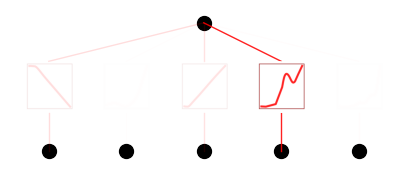

In [10]:
model_kan.plot()

In [ ]:
# model_kan.save_ckpt('kan_lastmlp.ckpt')
# model_kan = KAN(width=[122, 10, 10, 1], grid=5, k=3, seed=args.seed, device=device)
# model_kan.load_ckpt('kan_lastmlp.ckpt')
# model_kan.train(temp_dataset, opt="LBFGS", steps=1, lamb=0.01, loss_fn=criterion, device=device)
# model_kan.plot()

# obtaining symbolic formula
# formula, variables = model_kan.symbolic_formula()
# model_kan.suggest_symbolic(2,0,0)
# print(model_kan.symbolic_formula())
# formula[0]